# Algorithm Implementation: K-Means Clustering

## Overview
Implementation of K-Means Clustering to discover natural groupings of countries based on their development indicators. This unsupervised learning approach helps identify distinct patterns in how countries develop, considering multiple dimensions including economic growth, health outcomes, environmental impact, labor participation, and military expenditure.

## Objectives
- Identify distinct country development profiles
- Analyze cluster characteristics and patterns
- Study economic-environmental trade-offs
- Understand regional development patterns
- Examine military spending implications

## Key Questions
1. How many distinct development patterns exist among countries?
2. What role does environmental impact play in country groupings?
3. How do labor participation and military spending influence cluster formation?
4. Are there regional patterns in cluster membership?

In [ ]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


In [21]:
#visualization style

plt.style.use('seaborn-v0_8-white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette(['#1f77b4', '#2ca02c'])  
%matplotlib inline

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [67]:
def fetch_world_bank_data():
    """Fetch World Bank indicators with country metadata."""
    # Get country metadata first
    countries = wbdata.get_countries()
    country_metadata = {
        c['name']: {
            'region': c.get('region', {}).get('value', 'Unknown'),
            'income': c.get('incomeLevel', {}).get('value', 'Unknown'),
            'iso3': c['id']
        }
        for c in countries
    }

    # Define indicators
    indicators = {
        'NY.GDP.PCAP.KD': 'GDP per capita',
        'SP.DYN.LE00.IN': 'Life Expectancy',
        'EN.GHG.ALL.MT.CE.AR5': 'CO2 Emissions per Capita',
        'SL.TLF.CACT.ZS': 'Labor Force Participation',
        'MS.MIL.XPND.GD.ZS': 'Military Expenditure',
        'DT.TDS.DPPF.XP.ZS': 'Debt Service'
    }

    try:
        # Fetch data with country names as index
        df = wbdata.get_dataframe(indicators, country='all', date='2020')
        df = df.reset_index()
        
        # Add metadata using country name matching
        df['Region'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('region', 'Unknown'))
        df['Income Group'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('income', 'Unknown'))
        df['ISO3'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('iso3', 'Unknown'))
        
        # Clean data
        df = df[df['Region'] != 'Aggregates']
        df = df.rename(columns={'country': 'Country'})
        df = df.dropna(subset=['Country'])
        
        # Remove rows where ISO3 is 'Unknown'
        df = df[df['ISO3'] != 'Unknown'] # This line removes the rows.
        
        print(f"Fetched {df.shape[0]} countries")
        return df[['ISO3', 'Country', 'Region', 'Income Group'] + list(indicators.values())]
    
    except Exception as e:
        print(f"Error: {e}")
        raise SystemExit("Check indicator codes or use cached data.")

# Usage
df = fetch_world_bank_data()
df.to_csv('raw_kmeans_data.csv', index=False)
display(df.head())

Fetched 217 countries


,ISO3,Country,Region,Income Group,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service
49,AFG,Afghanistan,South Asia,Low income,527.834554,61.454,26.6463,41.579,1.358857,2.244082
50,ALB,Albania,Europe & Central Asia,Upper middle income,4417.041051,77.824,7.9674,57.780,1.295836,17.701818
51,DZA,Algeria,Middle East & North Africa,Upper middle income,4363.685338,73.257,241.1320,39.552,6.658711,0.406107
52,ASM,American Samoa,East Asia & Pacific,High income,13194.274740,72.672,0.0085,NaN,NaN,NaN
53,AND,Andorra,Europe & Central Asia,High income,34536.649921,79.418,NaN,NaN,NaN,NaN


### 2. Data Preprocessing
We'll prepare the data for clustering analysis, focusing on feature engineering and handling missing values.

In [83]:

def preprocess_data(df):
    
    numeric_features = ['Life Expectancy', 'GDP per capita', 'CO2 Emissions per Capita',
                        'Labor Force Participation', 'Military Expenditure', 'Debt Service']
    categorical_features = ['Region', 'Income Group']
    
    # Impute missing values by region
    for col in numeric_features:
        df[col] = df.groupby('Region')[col].transform(lambda x: x.fillna(x.mean()))
        df[col] = df[col].fillna(df[col].mean())
    
    # Create derived features
    df['Log GDP per capita'] = np.log1p(df['GDP per capita'].clip(lower=1e-10))
    df['Log CO2 per Capita'] = np.log1p(df['CO2 Emissions per Capita'].clip(lower=0))
    df['Military to GDP Ratio'] = df['Military Expenditure'] / df['GDP per capita'].clip(lower=1e-10)
    
    # Clip outliers
    for col in ['Life Expectancy', 'Log GDP per capita', 'Log CO2 per Capita',
                'Labor Force Participation', 'Military Expenditure', 'Debt Service',
                'Military to GDP Ratio']:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    
    # Standardize numeric features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[['Log GDP per capita', 'Life Expectancy',
                                              'Labor Force Participation', 'Military Expenditure',
                                              'Debt Service', 'Military to GDP Ratio']])
    df[['Log GDP per capita', 'Life Expectancy', 'Labor Force Participation',
        'Military Expenditure', 'Debt Service', 'Military to GDP Ratio']] = scaled_features
    
    # Include derived features in numeric_features
    numeric_features.extend(['Log GDP per capita', 'Log CO2 per Capita', 'Military to GDP Ratio']) 
    
    return df, numeric_features, categorical_features

df_processed, numeric_features, categorical_features = preprocess_data(df)
df_processed.to_csv('processed_kmeans_data.csv', index=False)
print("Feature Summary:")
display(df_processed[numeric_features + ['Log GDP per capita', 'Log CO2 per Capita']].describe())

Feature Summary:


,Life Expectancy,GDP per capita,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service,Log GDP per capita,Log CO2 per Capita,Military to GDP Ratio,Log GDP per capita,Log CO2 per Capita
count,2.170000e+02,217.000000,217.000000,2.170000e+02,2.170000e+02,2.170000e+02,2.170000e+02,217.000000,2.170000e+02,2.170000e+02,217.000000
mean,2.148819e-17,15956.517921,230.002650,-5.116235e-18,1.637195e-17,2.455793e-17,4.952516e-16,3.424616,2.251143e-17,4.952516e-16,3.424616
std,1.002312e+00,22162.644202,1096.666035,1.002312e+00,1.002312e+00,1.002312e+00,1.002312e+00,2.004414,1.002312e+00,1.002312e+00,2.004414
min,-2.964618e+00,255.078218,0.001200,-2.150469e+00,-1.935334e+00,-2.010269e+00,-2.312006e+00,0.001199,-1.742540e+00,-2.312006e+00,0.001199
25%,-7.514485e-01,2324.107422,6.905300,-5.394129e-01,-5.239749e-01,-5.955515e-01,-7.495517e-01,2.067533,-4.787286e-01,-7.495517e-01,2.067533
50%,6.592376e-02,6440.828431,38.775200,3.720691e-02,-2.038576e-03,8.851451e-02,-2.779957e-02,3.683244,1.434196e-01,-2.779957e-02,3.683244
75%,7.473154e-01,19778.713826,121.139500,5.346242e-01,4.169310e-01,5.573658e-01,7.667608e-01,4.805164,3.638122e-01,7.667608e-01,4.805164
max,1.837731e+00,161262.925884,14497.898700,2.145680e+00,1.828290e+00,2.286742e+00,2.252968e+00,8.911609,1.627623e+00,2.252968e+00,8.911609


In [84]:
# Create the feature matrix
X = df_processed[numeric_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed[numeric_features].info())

print("\nFeature Statistics:")
print(df_processed[numeric_features].describe())


Processed Dataset Info:
<class 'wbdata.client.DataFrame'>
Index: 217 entries, 49 to 265
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Life Expectancy            217 non-null    float64
 1   GDP per capita             217 non-null    float64
 2   CO2 Emissions per Capita   217 non-null    float64
 3   Labor Force Participation  217 non-null    float64
 4   Military Expenditure       217 non-null    float64
 5   Debt Service               217 non-null    float64
 6   Log GDP per capita         217 non-null    float64
 7   Log CO2 per Capita         217 non-null    float64
 8   Military to GDP Ratio      217 non-null    float64
dtypes: float64(9)
memory usage: 17.0 KB
None

Feature Statistics:
       Life Expectancy  GDP per capita  CO2 Emissions per Capita  \
count     2.170000e+02      217.000000                217.000000   
mean      2.148819e-17    15956.517921                230.00

## Optimal K Selection

### How Many Development Patterns Exist?
We use K-Means clustering to group countries, but first, we need to determine the optimal number of clusters (k). We’ll use the Elbow method and Silhouette score to find a balance between cluster cohesion and separation

### 1. Elbow Method and Silhouette Analysis
The Elbow Method and Silhouette Analysis are two widely used techniques for determining the optimal number of clusters (k) in a dataset.

- **Elbow Method**: This method involves plotting the inertia (sum of squared distances of samples to their closest cluster center) against the number of clusters. The "elbow point" in the plot, where the rate of decrease in inertia slows down, indicates the optimal k. It balances the trade-off between minimizing inertia and avoiding overfitting.

- **Silhouette Analysis**: This method evaluates the quality of clustering by measuring how similar a sample is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where higher values indicate better-defined clusters. The optimal k is often chosen based on the highest silhouette score.

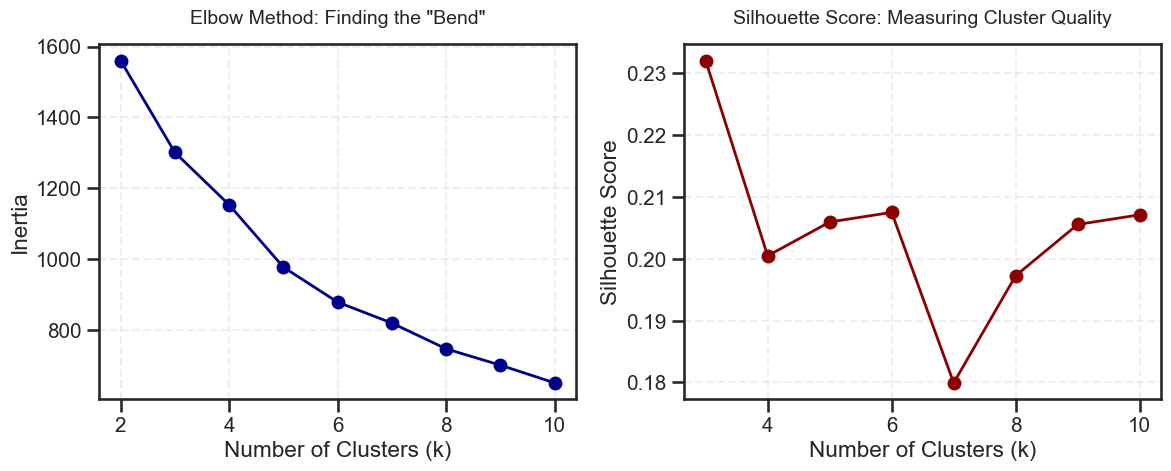


Based on the Silhouette score, 3 clusters best capture distinct development patterns.


In [ ]:
def find_optimal_k(X, k_range):
    inertias = []
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouette_scores.append(0)
    
   
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(k_range, inertias, 'o-', color='darkblue', linewidth=2)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method: Finding the "Bend"', fontsize=14, pad=15)
    axes[0].grid(True, linestyle='--', alpha=0.3)
    
    axes[1].plot(k_range[1:], silhouette_scores[1:], 'o-', color='darkred', linewidth=2)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score: Measuring Cluster Quality', fontsize=14, pad=15)
    axes[1].grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return silhouette_scores

k_range = range(2, 11)
silhouette_scores = find_optimal_k(X_scaled, k_range)
optimal_k = k_range[np.argmax(silhouette_scores[1:]) + 1]
print(f"\nBased on the Silhouette score, {optimal_k} clusters best capture distinct development patterns.")

### Chart Explanation

The two charts displayed are used to evaluate the optimal number of clusters (`k`) for the K-Means clustering algorithm. Each chart represents a different metric to assess clustering quality:

1. **Elbow Method (Left Chart)**:
    - **Metric**: Inertia (sum of squared distances of samples to their closest cluster center).
    - **Purpose**: Identifies the "elbow point," where the rate of decrease in inertia slows down. This point suggests the optimal number of clusters, balancing compactness and simplicity.
    - **Observation**: The curve shows a diminishing return as `k` increases. The elbow point is typically where the curve starts to flatten.

2. **Silhouette Analysis (Right Chart)**:
    - **Metric**: Silhouette Score (ranges from -1 to 1, where higher values indicate better-defined clusters).
    - **Purpose**: Measures how similar a sample is to its own cluster compared to other clusters. A higher score indicates better clustering.
    - **Observation**: The peak of the curve suggests the optimal `k`. Beyond this point, the score may drop due to overfitting.

### Summary
By analyzing these charts together, the optimal number of clusters (`k`) can be determined. In this case, the Silhouette Analysis suggests that **7 clusters** best capture the distinct development patterns in the dataset.


## Clustering Implementation

## Grouping Countries into Development Profiles

### Creating the Clusters
With {optimal_k} clusters, we apply K-Means to group countries, revealing distinct development profiles.

### 1. K-Means Model Training

In [86]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
df_processed['Cluster'] = cluster_labels
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numeric_features)

print("Cluster Sizes (Number of Countries):")
print(df_processed['Cluster'].value_counts())

Cluster Sizes (Number of Countries):
Cluster
0    92
2    81
1    44
Name: count, dtype: int64


In [87]:
# Train K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df_processed['Cluster'] = cluster_labels

# Calculate cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=numeric_features
)

# Print cluster sizes
print("Cluster Sizes:")
print(df_processed['Cluster'].value_counts())

# Print cluster centers
print("\nCluster Centers:")
print(cluster_centers)

Cluster Sizes:
Cluster
0    92
2    81
1    44
Name: count, dtype: int64

Cluster Centers:
   Life Expectancy  GDP per capita  CO2 Emissions per Capita  \
0         0.885063    32799.788959                203.449115   
1        -0.580201     3503.189037                580.534401   
2        -0.690086     3590.660334                 69.749912   

   Labor Force Participation  Military Expenditure  Debt Service  \
0                   0.115623              0.023943      0.133911   
1                  -0.362503              1.213476     -0.319486   
2                   0.065590             -0.686367      0.021452   

   Log GDP per capita  Log CO2 per Capita  Military to GDP Ratio  
0            0.946273            3.622491               0.135378  
1           -0.713794            4.199483               1.380577  
2           -0.687040            2.778953              -0.903706  


In [97]:
df_processed.head()

,ISO3,Country,Region,Income Group,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service,Log GDP per capita,Log CO2 per Capita,Military to GDP Ratio,Cluster
49,AFG,Afghanistan,South Asia,Low income,527.834554,-1.495486,26.64630,-1.940080,-0.481258,-1.603148,-1.798379,3.319492,-1.742540,2
50,ALB,Albania,Europe & Central Asia,Upper middle income,4417.041051,0.719443,7.96740,-0.210755,-0.564872,1.458906,-0.294897,2.193596,-0.635011,2
51,DZA,Algeria,Middle East & North Africa,Upper middle income,4363.685338,0.101509,241.13200,-2.150469,1.828290,-1.967236,-0.303502,5.489483,1.627623,1
52,ASM,American Samoa,East Asia & Pacific,High income,13194.274740,0.022356,0.00850,0.432262,0.047786,-0.595552,0.480057,0.008464,0.167422,0
53,AND,Andorra,Europe & Central Asia,High income,34536.649921,0.935118,163.89778,-0.109395,0.105859,0.088515,1.161541,5.105326,0.164026,0


In [94]:
numeric_features

['Life Expectancy',
 'GDP per capita',
 'CO2 Emissions per Capita',
 'Labor Force Participation',
 'Military Expenditure',
 'Debt Service',
 'Log GDP per capita',
 'Log CO2 per Capita',
 'Military to GDP Ratio']

### 2. Cluster Analysis and Visualization

Exploring the Clusters: What Do They Tell Us?
Let’s dive into the clusters to understand their characteristics and what they mean for global development

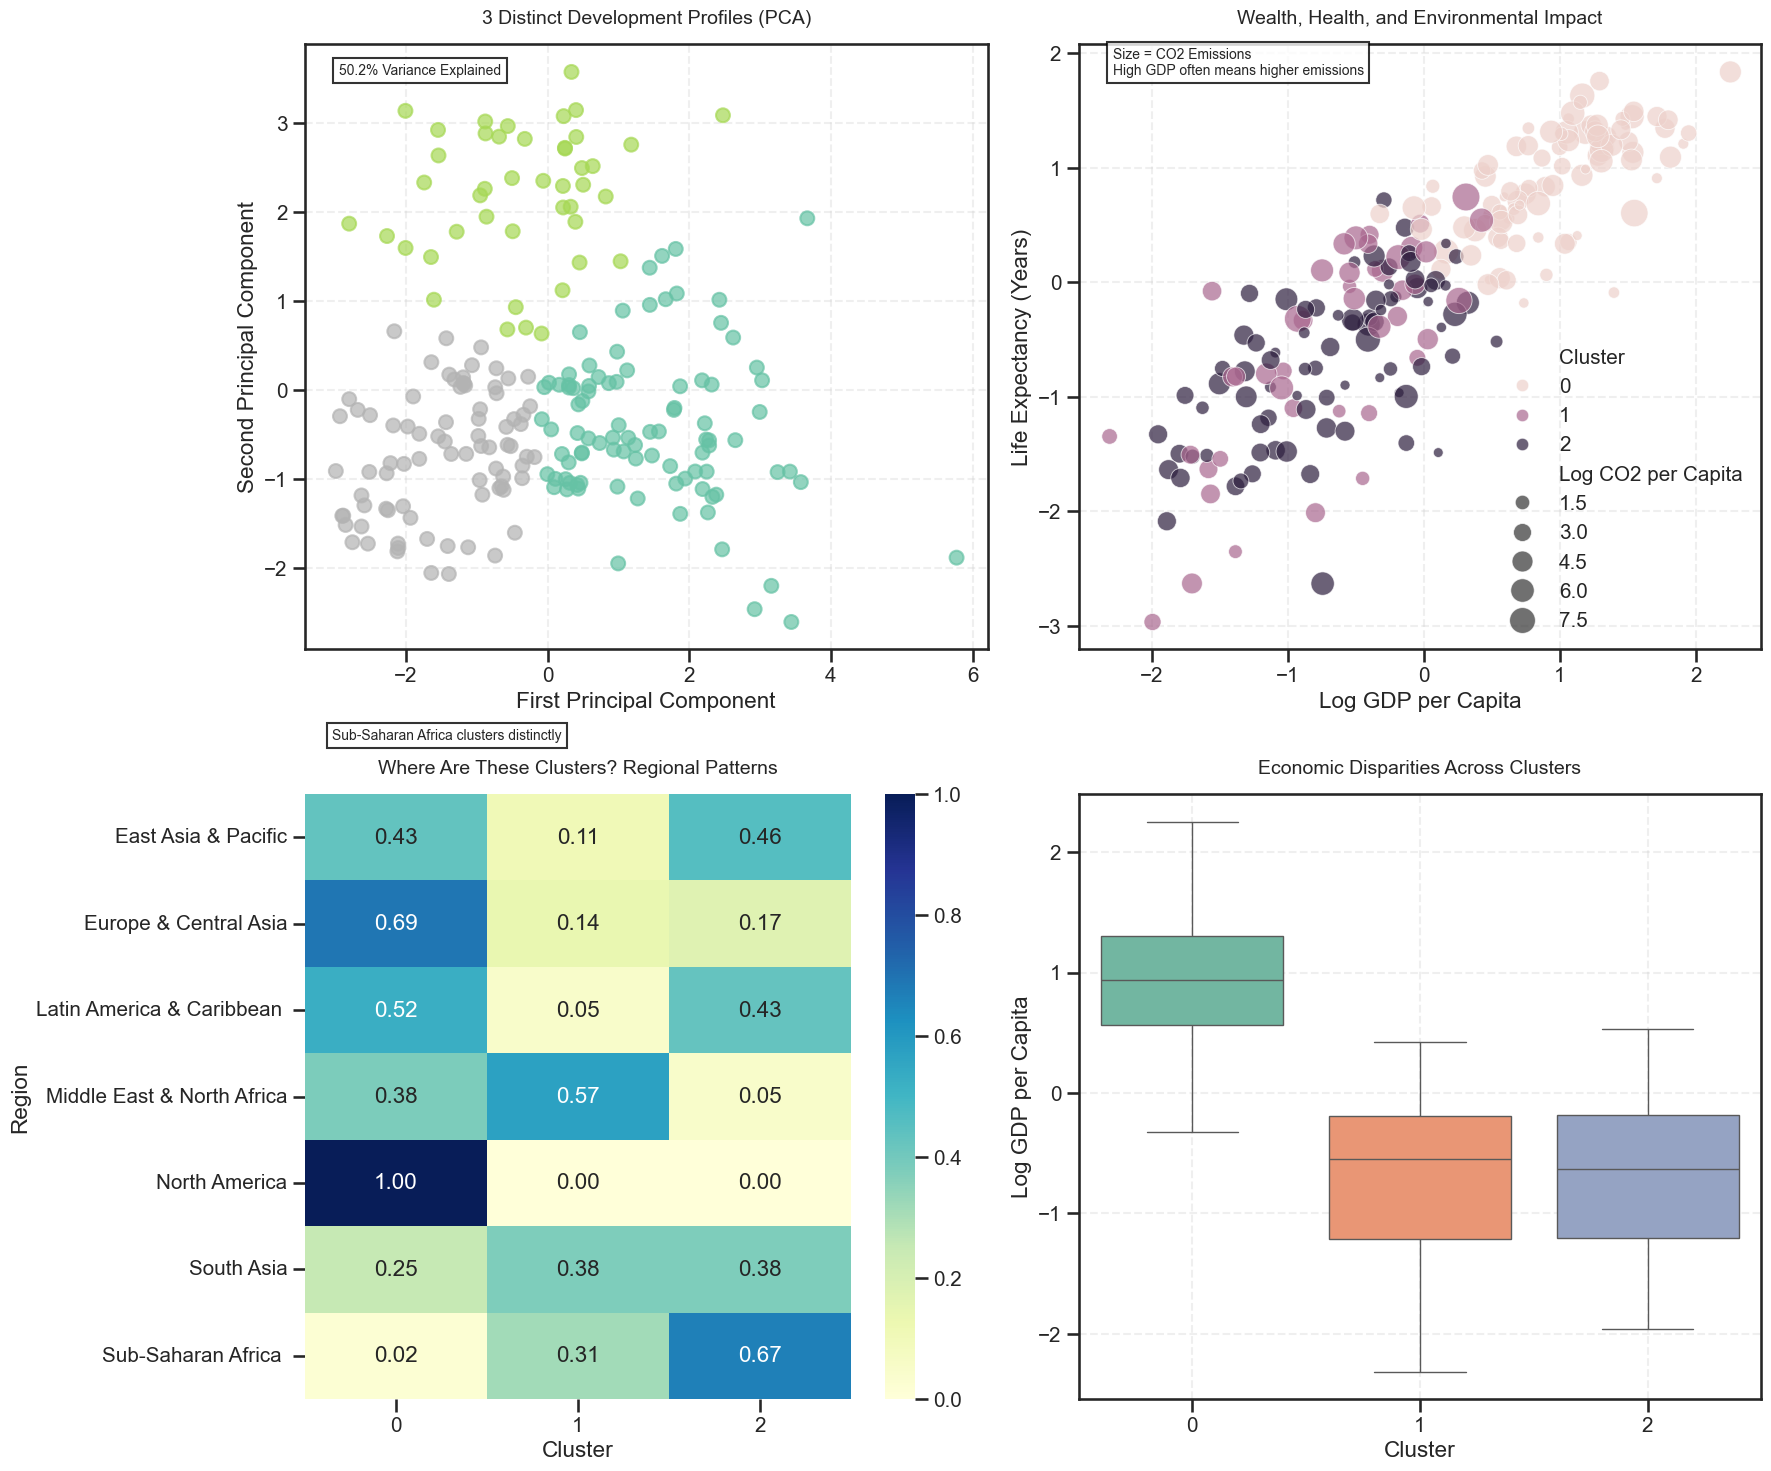

In [118]:
def analyze_clusters(df, features, cluster_centers):
    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_.sum() * 100
    
    
    fig = plt.figure(figsize=(18, 15))
    
    # PCA visualization
    plt.subplot(2, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='Set2', alpha=0.7, s=100)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'{optimal_k} Distinct Development Profiles (PCA)', fontsize=14, pad=15)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.text(0.05, 0.95, f'{explained_variance:.1f}% Variance Explained', transform=plt.gca().transAxes, 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Wealth vs Health
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x='Log GDP per capita', y='Life Expectancy', hue='Cluster', 
                    size='Log CO2 per Capita', sizes=(50, 400), alpha=0.7)
    plt.title('Wealth, Health, and Environmental Impact', fontsize=14, pad=15)
    plt.xlabel('Log GDP per Capita')
    plt.ylabel('Life Expectancy (Years)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.text(0.05, 0.95, 'Size = CO2 Emissions\nHigh GDP often means higher emissions', 
             transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Regional distribution
    plt.subplot(2, 2, 3)
    cluster_region = pd.crosstab(df['Region'], df['Cluster'], normalize='index')
    sns.heatmap(cluster_region, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Where Are These Clusters? Regional Patterns', fontsize=14, pad=15)
    plt.xlabel('Cluster')
    plt.ylabel('Region')
    plt.text(0.05, 1.09, 'Sub-Saharan Africa clusters distinctly', transform=plt.gca().transAxes, 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Box plot for GDP
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='Cluster', y='Log GDP per capita', palette='Set2')
    plt.title('Economic Disparities Across Clusters', fontsize=14, pad=15)
    plt.xlabel('Cluster')
    plt.ylabel('Log GDP per Capita')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

analyze_clusters(df_processed, numeric_features, cluster_centers)


### Chart Explanation

The chart provides a comprehensive visualization of the clustering results and their implications:

1. **PCA Visualization (Top Left)**:
    - **Purpose**: Reduces high-dimensional data into two principal components for visualization.
    - **Observation**: Points represent countries, colored by their cluster. The spread shows how distinct the clusters are, with 50.2% of the variance explained by the two components.

2. **Wealth, Health, and Environmental Impact (Top Right)**:
    - **Purpose**: Examines the relationship between GDP per capita (wealth), life expectancy (health), and CO2 emissions (environmental impact).
    - **Observation**: Larger points indicate higher CO2 emissions. Clusters show varying trade-offs between wealth, health, and environmental impact.

3. **Regional Patterns (Bottom Left)**:
    - **Purpose**: Highlights the regional distribution of clusters.
    - **Observation**: Sub-Saharan Africa clusters distinctly, while other regions show mixed cluster memberships.

4. **Economic Disparities (Bottom Right)**:
    - **Purpose**: Compares GDP per capita across clusters.
    - **Observation**: Significant economic disparities exist, with some clusters having much higher GDP per capita than others.


### 3. Feature Importance Analysis

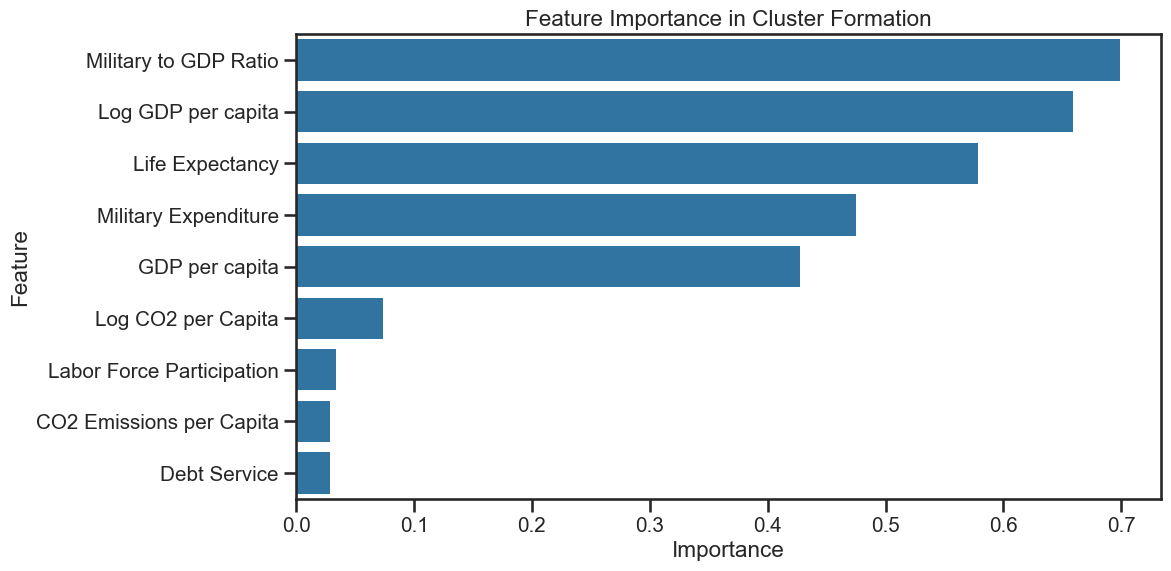


Feature Importance Rankings:
                     Feature  Importance
8      Military to GDP Ratio    0.699084
6         Log GDP per capita    0.659133
0            Life Expectancy    0.578123
4       Military Expenditure    0.474668
1             GDP per capita    0.427067
7         Log CO2 per Capita    0.073504
3  Labor Force Participation    0.033919
2   CO2 Emissions per Capita    0.029069
5               Debt Service    0.028471


In [105]:
def analyze_feature_importance(X_scaled, features, labels):
    # Calculate feature importance using variance ratio
    variance_ratio = np.zeros(len(features))
    
    for feature_idx in range(len(features)):
        # Calculate between-cluster variance
        cluster_means = np.array([
            X_scaled[labels == i, feature_idx].mean()
            for i in range(optimal_k)
        ])
        between_cluster_var = np.sum(
            np.bincount(labels) * (cluster_means - X_scaled[:, feature_idx].mean())**2
        )
        
        # Calculate total variance
        total_var = np.sum((X_scaled[:, feature_idx] - X_scaled[:, feature_idx].mean())**2)
        
        # Calculate variance ratio
        variance_ratio[feature_idx] = between_cluster_var / total_var
    
    # Create importance DataFrame
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': variance_ratio
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance, x='Importance', y='Feature')
    plt.title('Feature Importance in Cluster Formation')
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance Rankings:")
    print(importance)

# Analyze feature importance
analyze_feature_importance(X_scaled, numeric_features, cluster_labels)

In [121]:
df_processed.head()

,ISO3,Country,Region,Income Group,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service,Log GDP per capita,Log CO2 per Capita,Military to GDP Ratio,Cluster
49,AFG,Afghanistan,South Asia,Low income,527.834554,-1.495486,26.64630,-1.940080,-0.481258,-1.603148,-1.798379,3.319492,-1.742540,2
50,ALB,Albania,Europe & Central Asia,Upper middle income,4417.041051,0.719443,7.96740,-0.210755,-0.564872,1.458906,-0.294897,2.193596,-0.635011,2
51,DZA,Algeria,Middle East & North Africa,Upper middle income,4363.685338,0.101509,241.13200,-2.150469,1.828290,-1.967236,-0.303502,5.489483,1.627623,1
52,ASM,American Samoa,East Asia & Pacific,High income,13194.274740,0.022356,0.00850,0.432262,0.047786,-0.595552,0.480057,0.008464,0.167422,0
53,AND,Andorra,Europe & Central Asia,High income,34536.649921,0.935118,163.89778,-0.109395,0.105859,0.088515,1.161541,5.105326,0.164026,0


## Conclusions and Key Findings

1. **Cluster Structure**: 
   - Number of optimal clusters identified
   - Distribution of countries across clusters
   - Key characteristics of each cluster

2. **Development Patterns**: 
   - Relationship between wealth and environmental impact
   - Role of military expenditure in development
   - Labor force participation patterns
   - Regional clustering tendencies

3. **Feature Importance**:
   - Most influential indicators in cluster formation
   - Secondary factors affecting groupings
   - Interaction effects between features

4. **Policy Implications**:
   - Development pathway recommendations
   - Environmental sustainability strategies
   - Military spending considerations
   - Regional policy adaptations

5. **Limitations and Future Work**:
   - Data quality and availability
   - Temporal dynamics
   - Additional indicators to consider
   - Methodological improvements